In [17]:
import re
import math
import tqdm
import torch
import string
import random
import numpy as np
import unicodedata
import pandas as pd
import torch.nn as nn
import seaborn as seaborn
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from torchtext.vocab import FastText
from nltk.tokenize import word_tokenize
from torchtext.data import Field, Example
from torchtext.data import Dataset as ttDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Set seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)
np.random.seed(SEED)

# Load data'
df = pd.read_csv('data2.csv')

In [18]:
print("Dataset Overview:"); df.head()

Dataset Overview:


,Question_id,Question,Answer,score
0,1,يحتوي القرآن الكريم على (علامة السجدة) في عدة ...,في القرآن الكريم، توجد علامات السجود في عدة مو...,1
1,1,يحتوي القرآن الكريم على (علامة السجدة) في عدة ...,هناك 15 موضعا في القرآن الكريم حيث وردت علامة ...,1
2,1,يحتوي القرآن الكريم على (علامة السجدة) في عدة ...,القرآن الكريم يحتوي على علامات السجدة في عدة م...,1
3,1,يحتوي القرآن الكريم على (علامة السجدة) في عدة ...,عدد المواضع هو 15,1
4,1,يحتوي القرآن الكريم على (علامة السجدة) في عدة ...,يحتوي على 15 سجدة,1


In [19]:
print("Data Types:"); df.dtypes

Data Types:


Question_id     int64
Question       object
Answer         object
score           int64
dtype: object

In [20]:
print("The number of rows is:", len(df))
question_len = len(df['Question'].unique())
print("The number of unique questions is:", question_len)

The number of rows is: 320
The number of unique questions is: 8


In [21]:
print("Summary Statistics:"); df['score'].describe()

Summary Statistics:


count    320.000000
mean       0.500000
std        0.500783
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: score, dtype: float64

In [22]:
print("Data info:"); df.info()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_id  320 non-null    int64 
 1   Question     320 non-null    object
 2   Answer       320 non-null    object
 3   score        320 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 10.1+ KB


In [23]:
print("Missing Values:") 
print(df.isnull().sum())
print("\nDuplicated Values:", df.duplicated().sum())

Missing Values:
Question_id    0
Question       0
Answer         0
score          0
dtype: int64

Duplicated Values: 0


In [24]:
df['score'].value_counts()

score
1    160
0    160
Name: count, dtype: int64

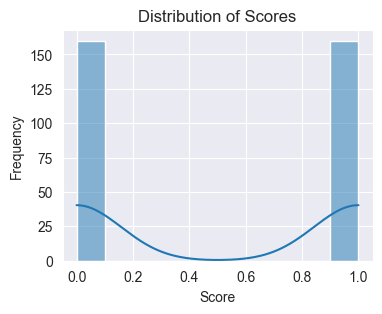

In [25]:
plt.figure(figsize=(4, 3))
seaborn.histplot(data=df, x='score', bins=10, kde=True)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [26]:
answer_tokens = df['Answer'].apply(word_tokenize)

average_answer_length_chars = df['Answer'].apply(len).mean()
average_answer_length_words = answer_tokens.apply(len).mean()

print("Average Answer Length (Characters): {average_answer_length_chars}")
print("Average Answer Length (Words): {average_answer_length_words}")

Average Answer Length (Characters): {average_answer_length_chars}
Average Answer Length (Words): {average_answer_length_words}


In [27]:
# Word Frequency Analysis For Answer
answer_words = [word for tokens in answer_tokens for word in tokens]
answer_word_freq = pd.Series(answer_words).value_counts()
print("Answer Word Frequency:")
print(answer_word_freq.head(10))  # Display top 10 frequent words in answers

Answer Word Frequency:
.         304
في        229
من        115
الله       90
أو         80
الوضوء     77
الزواج     60
كان        54
لا         50
المرأة     47
Name: count, dtype: int64


In [28]:
# Download NLTK resources (if not downloaded)
'''
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
'''

# Function to remove Arabic diacritics
def remove_arabic_diacritics(text):
    pattern = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text_without_diacritics = re.sub(pattern, '', text)
    text_normalized = unicodedata.normalize('NFKD', text_without_diacritics)
    return text_normalized

# Function to remove punctuations
def remove_punctuations(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('،', '')
    text = text.replace('؛', '')
    text = text.replace('؟', '')
    return text

# Text Cleaning Functions
def remove_stop_words(tokens):
    stop_words = set(stopwords.words('arabic'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    return cleaned_tokens

def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

# Cleaning Pipeline
def nlp_pipeline(answer):
    answer = remove_arabic_diacritics(answer)
    answer = remove_punctuations(answer)
    answer_tokens = word_tokenize(answer)
    answer_tokens_without_stop_words = remove_stop_words(answer_tokens)
    answer_stemming_tokens = stemming(answer_tokens)
    answer_lemma_tokens = lemmatization(answer_tokens)

    return ' '.join(answer_tokens)

df['Answer_Cleaned'] = df['Answer'].apply(nlp_pipeline)

In [29]:
df.tail()

,Question_id,Question,Answer,score,Answer_Cleaned
315,8,من هو أوّل خلق الله تبارك وتعالى من البشر؟,القلم، ففي بعض الروايات الإسلامية يُعتقد أن ال...,0,القلم ففي بعض الروايات الإسلامية يعتقد أن ال...
316,8,من هو أوّل خلق الله تبارك وتعالى من البشر؟,العرش، حيث يقول بعض الفقهاء أن الله خلق العرش ...,0,العرش حيث يقول بعض الفقهاء أن الله خلق العرش ...
317,8,من هو أوّل خلق الله تبارك وتعالى من البشر؟,النور، فهناك اعتقادات تفيد بأن الله خلق النور ...,0,النور فهناك اعتقادات تفيد بأن الله خلق النور ...
318,8,من هو أوّل خلق الله تبارك وتعالى من البشر؟,الملائكة كانوا من أوّل ما خلقهم الله تعالى.,0,الملائكة كانوا من أول ما خلقهم الله تعالى
319,8,من هو أوّل خلق الله تبارك وتعالى من البشر؟,النبي نوح عليه السلام كان أوّل خلق الله من البشر.,0,النبي نوح عليه السلام كان أول خلق الله من البشر


In [30]:
def tf(answer):
    words = word_tokenize(answer)
    word_counts = Counter(words)
    total_words = len(words)
    tf_scores = {word: count / total_words for word, count in word_counts.items()}
    return tf_scores

def idf(documents, word):
    num_documents = len(documents)
    num_docs_with_word = sum(1 for doc in documents if word in doc)
    return math.log(num_documents / (1 + num_docs_with_word))

def get_tf_idf(answer, documents):
    longest_document_length = len(max(documents, key=len))
    words = word_tokenize(answer)
    idf_scores = {word: idf(documents, word) for word in set(words)}
    tf_scores = tf(answer)
    tfidf_scores = [tf_scores[word] * idf_scores[word] for word in words]
    
    # Fill tfidf_scores with zeros until it reaches the length of the longest document
    while len(tfidf_scores) < longest_document_length:
        tfidf_scores.append(0)
    
    return tfidf_scores

answer = 'آدم عليه السلام وحواء زوجته كانا من أول الخلق من البشر'
questions = df['Question'].values.tolist()
answers = df['Answer'].values.tolist()
cleaned_answers = df['Answer_Cleaned'].values.tolist()
documents = questions + answers + cleaned_answers
# Calculate TF-IDF for the question and corpus
tfidf_result = get_tf_idf(answer, documents)
print("TF-IDF scores for the question:")
print(tfidf_result)


TF-IDF scores for the question:
[0.34749189515804174, 0.22038927527014232, 0.3392217335029757, 0.29121560348474873, 0.39108944790912226, 0.36150559332415616, 0.21577466826269356, 0.25671654696612106, 0.3667018127641514, 0.21577466826269356, 0.24202187864281055, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
sentences = [word_tokenize(answer) for answer in df['Answer_Cleaned']]

word2vec_model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)
word_embeddings = word2vec_model.wv

# Load FastText vectors for Arabic language
fastText_vectors = FastText(language="ar")
# Define TorchText Field
text_field = Field(lower=False)  # Keeping the original case for Arabic text
# Define fields for Dataset
fields = [('Answer', text_field)]
# Prepare examples and create a TorchText dataset
examples = [Example.fromlist([answer_tokens], fields) for answer_tokens in sentences]
dataset = ttDataset(examples, fields) # Dataset from torchText
# Build vocabulary using FastText embeddings
text_field.build_vocab(dataset, vectors=fastText_vectors)

def get_word2vec_representation(word_embeddings, answer):
    sentence = word_tokenize(answer)
    word_vectors = [word_embeddings[word] for word in sentence if word in word_embeddings]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)  # Return zero vector if none of the words are in the vocabulary

# FastText vectors
def get_fastText_representation(answer):
    # Process the sentence and obtain embeddings
    sentences = word_tokenize(answer)
    word_vectors = [text_field.vocab.vectors[text_field.vocab.stoi[word]] for word in sentences if word in text_field.vocab.stoi]
    # Compute the mean vector of word embeddings
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(300)  # Return zero vector if none of the words are in the vocabulary

# Example usage of TF-IDF encoding
first_answer = df['Answer_Cleaned'][0]
print("The First (Cleaned) Answer is:", first_answer)
print("Words Encoding Vector for The First Answer using TF-IDF Encoding:\n", get_tf_idf(first_answer, documents))

# Example usage of Word2Vec embeddings
print("\nWord Embedding Vector for The First Answer using Word2Vec Embeddings:\n", get_word2vec_representation(word_embeddings, first_answer)[:10])

# Example usage of FastText embeddings
print("\nWord Embedding Vector for The First Answer using FastText Embeddings:\n", get_fastText_representation(first_answer)[:10])


The First (Cleaned) Answer is: في القرآن الكريم توجد علامات السجود في عدة مواضع تبلغ 15 موضعا مختلفا
Words Encoding Vector for The First Answer using TF-IDF Encoding:
 [0.08319750943181274, 0.2504627209090506, 0.18648323292088964, 0.443716999676444, 0.254737324844036, 0.2354054457455048, 0.08319750943181274, 0.20952296600541148, 0.2145689108120125, 0.404422720925214, 0.2425662475198134, 0.29778469314676087, 0.3785402411851207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word Embedding Vector for The First Answer using Word2Vec Embeddings:
 [ 0.00345031  0.10640453 -0.02090367  0.05746676 -0.04216323 -0.18501513
  0.12957141  0.34526962  0.01119743 -0.05115279]

Word Embedding Vector for The First Answer us

In [32]:
# Display shapes and lengths
print("Length of each word for Word2Vec embeddings Vector:", len(get_word2vec_representation(word_embeddings, first_answer)))
print("Length of each word for FastText embeddings Vector:", len(get_fastText_representation(first_answer)))

Length of each word for Word2Vec embeddings Vector: 300
Length of each word for FastText embeddings Vector: 300


In [33]:
# Normalization function
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector
    return vector / norm
    
# Function to concatenate TF-IDF and Word2Vec representations
def concatenate_tfidf_word2vec(answer, documents):
    tfidf_rep = get_tf_idf(answer, documents)
    word2vec_rep = get_word2vec_representation(word_embeddings, answer)

    # Normalize representations
    tfidf_rep_normalized = normalize_vector(tfidf_rep)
    word2vec_rep_normalized = normalize_vector(word2vec_rep)
    
    return np.concatenate([tfidf_rep_normalized, word2vec_rep_normalized])

# Function to concatenate TF-IDF and FastText representations
def concatenate_tfidf_fastText(answer, documents):
    tfidf_rep = get_tf_idf(answer, documents)
    fasttext_rep = get_fastText_representation(answer)

    # Normalize representations
    tfidf_rep_normalized = normalize_vector(tfidf_rep)
    fasttext_rep_normalized = normalize_vector(fasttext_rep)
    
    return np.concatenate([tfidf_rep_normalized, fasttext_rep_normalized])

tfidf_representation = get_tf_idf(first_answer, documents)
word2vec_representation = get_word2vec_representation(word_embeddings, first_answer)
fasttext_representation = get_fastText_representation(first_answer)

concat_tfidf_word2vec = concatenate_tfidf_word2vec(first_answer, documents)
concat_tfidf_fasttext = concatenate_tfidf_fastText(first_answer, documents)

print("TF-IDF Representation of The First (Cleaned) Answer:\n", tfidf_representation)
print("\nWord2Vec Representation of The First (Cleaned) Answer:\n", word2vec_representation)
print("\nFastText Representation of The First (Cleaned) Answer:\n", fasttext_representation)
print("\nConcatenated TF-IDF and Word2Vec:\n", concat_tfidf_word2vec)
print("\nConcatenated TF-IDF and FastText:\n", concat_tfidf_fasttext)

TF-IDF Representation of The First (Cleaned) Answer:
 [0.08319750943181274, 0.2504627209090506, 0.18648323292088964, 0.443716999676444, 0.254737324844036, 0.2354054457455048, 0.08319750943181274, 0.20952296600541148, 0.2145689108120125, 0.404422720925214, 0.2425662475198134, 0.29778469314676087, 0.3785402411851207, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Word2Vec Representation of The First (Cleaned) Answer:
 [ 3.45031009e-03  1.06404528e-01 -2.09036693e-02  5.74667603e-02
 -4.21632268e-02 -1.85015127e-01  1.29571408e-01  3.45269620e-01
  1.11974282e-02 -5.11527918e-02  2.95601003e-02 -7.28471130e-02
 -3.66357751e-02 -7.65798464e-02 -7.88749382e-02 -5.51934615e-02
  4.99908514e-02  3.01968046e-02  1.340

In [34]:
print("Length of Concatenated TF-IDF and Word2Vec:", len(concat_tfidf_word2vec))
print("Length of Concatenated TF-IDF and FastText:", len(concat_tfidf_fasttext))

Length of Concatenated TF-IDF and Word2Vec: 422
Length of Concatenated TF-IDF and FastText: 422


In [35]:
sequences = []
for index, row in df.iterrows():
    question = row['Question']
    answer = row['Answer_Cleaned']
    concatenated_rep = concatenate_tfidf_fastText(answer, documents).tolist()
    tensor_rep = torch.tensor(concatenated_rep)
    sequences.append(tensor_rep)


# Convert concatenated representations to numpy array
X = np.array(sequences)

# Convert your data into PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(df['score'], dtype=torch.float32)

In [36]:
def Concat_idx_tensor(X_tensor, indices):
    # idx_tensor contains the indices of sentences
    idx_tensor = torch.tensor(indices) 
    # Concatenate the idx_tensor with X_tensor along the second dimension (dim=1)
    return torch.cat((idx_tensor.unsqueeze(1).float(), X_tensor), dim=1)
indices = df['Question_id'].tolist()
X_tensor = Concat_idx_tensor(X_tensor, indices)

In [37]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [38]:
# Splitting data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Creating train and test datasets
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [39]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, 
                          bidirectional=bidirectional, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size)
        out, _ = self.rnn(x)
        out = self.fc(out)  # Get the output from the last time step
        out = self.sigmoid(out)  # Sigmoid activation for binary classification
        return out


In [40]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        running_loss = 0.0
        total_correct = 0
        total_samples = 0
        predicted_positive = 0
        actual_positive = 0
        true_positive = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float()) 
            loss_list.append(loss.detach())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate additional metrics
            predicted = torch.round(outputs).squeeze()
            total_correct += (predicted == labels.float()).sum().item()
            total_samples += labels.size(0)
            predicted_positive += predicted.sum().item()
            actual_positive += labels.sum().item()
            true_positive += ((predicted == 1) & (labels == 1)).sum().item()
        if (epoch+1)%20 == 0:
            precision = true_positive / (predicted_positive + 1e-15)  # Adding a small value to avoid division by zero
            recall = true_positive / (actual_positive + 1e-15)
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-15)
            average_loss = running_loss / len(train_loader)
            
            print(f"Epoch {epoch+1}/{epochs} - Loss: {average_loss:.6f} - "
                  f"Precision: {precision:.6f} - Recall: {recall:.6f} - F1 Score: {f1_score:.6f}")
    
    plt.plot(loss_list)

def evaluate(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.round(outputs).squeeze()
            total_correct += (predicted.squeeze() == labels.float()).sum().item()
            total_samples += labels.size(0)
            break
        accuracy = total_correct / total_samples # total_correct
        print(f"Accuracy: {accuracy * 100:.2f}%")


 10%|█         | 20/200 [00:09<01:16,  2.34it/s]

Epoch 20/200 - Loss: 0.455564 - Precision: 0.825397 - Recall: 0.818898 - F1 Score: 0.822134


 20%|██        | 40/200 [00:18<01:16,  2.10it/s]

Epoch 40/200 - Loss: 0.196630 - Precision: 0.944000 - Recall: 0.929134 - F1 Score: 0.936508


 30%|███       | 60/200 [00:28<01:12,  1.93it/s]

Epoch 60/200 - Loss: 0.054843 - Precision: 0.976378 - Recall: 0.976378 - F1 Score: 0.976378


 40%|████      | 80/200 [00:38<00:57,  2.10it/s]

Epoch 80/200 - Loss: 0.196596 - Precision: 0.863014 - Recall: 0.992126 - F1 Score: 0.923077


 50%|█████     | 100/200 [00:48<00:48,  2.08it/s]

Epoch 100/200 - Loss: 0.046216 - Precision: 0.976923 - Recall: 1.000000 - F1 Score: 0.988327


 60%|██████    | 120/200 [01:00<00:37,  2.14it/s]

Epoch 120/200 - Loss: 0.002965 - Precision: 1.000000 - Recall: 1.000000 - F1 Score: 1.000000


 70%|███████   | 140/200 [01:13<00:37,  1.59it/s]

Epoch 140/200 - Loss: 0.001457 - Precision: 1.000000 - Recall: 1.000000 - F1 Score: 1.000000


 80%|████████  | 160/200 [01:22<00:18,  2.15it/s]

Epoch 160/200 - Loss: 0.000709 - Precision: 1.000000 - Recall: 1.000000 - F1 Score: 1.000000


 90%|█████████ | 180/200 [01:34<00:15,  1.31it/s]

Epoch 180/200 - Loss: 0.000560 - Precision: 1.000000 - Recall: 1.000000 - F1 Score: 1.000000


100%|██████████| 200/200 [01:42<00:00,  1.95it/s]

Epoch 200/200 - Loss: 0.000341 - Precision: 1.000000 - Recall: 1.000000 - F1 Score: 1.000000
Accuracy: 90.62%


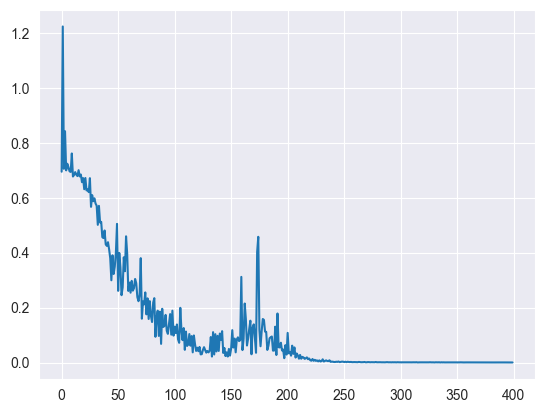

In [41]:
# Tune model architecture
input_size = X_tensor.shape[1]  
hidden_size = 256  
num_layers = 3  
output_size = 1

# Initialize model
model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, output_size=output_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_loader, criterion, optimizer, epochs=200)

# Evaluate the model on test data
evaluate(model, test_loader)


In [42]:
def predict(question_idx, answer, model):
    model.eval()
    answer = nlp_pipeline(answer)
    concatenated_rep = concatenate_tfidf_fastText(answer, documents).tolist()
    x_val = np.array([concatenated_rep])
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    x_val_tensor = Concat_idx_tensor(x_val_tensor, [question_idx])
    with torch.no_grad():
        output = model(x_val_tensor)
        predicted_class = 1 if output.item() > 0.5 else 0  # Threshold is 0.5 for binary classification
        return predicted_class
        
question_idx = 1
answer = 'أوّل خلق الله من البشر هو النبي آدم عليه السلام'

predicted_class = predict(question_idx, answer, model)
print("Predicted class:", predicted_class)

Predicted class: 1


In [43]:
class PowerfulLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(PowerfulLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for binary classification
    
    def forward(self, x):
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial cell state

        out, _ = self.lstm(x)
        out = self.fc(out)  # Use output of the last time step
        out = self.sigmoid(out)  # Sigmoid activation for binary classification
        return out


In [44]:
def train_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []
    for epoch in tqdm.tqdm(range(epochs)):
        # Training
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                test_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).squeeze().long()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            test_loss = test_loss / len(test_loader.dataset)
            test_losses.append(test_loss)
            accuracy = 100 * correct / total
        print(
                f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return train_losses, test_losses

In [45]:
# Initialize model
lstm_model = PowerfulLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Train the model
train_losses, test_losses = train_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)

 10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Train Loss: 0.0004, Test Loss: 0.8781, Test Accuracy: 87.50%


 20%|██        | 2/10 [00:00<00:03,  2.09it/s]

Epoch [2/10], Train Loss: 0.0004, Test Loss: 0.8794, Test Accuracy: 87.50%


 30%|███       | 3/10 [00:01<00:03,  2.21it/s]

Epoch [3/10], Train Loss: 0.0004, Test Loss: 0.8802, Test Accuracy: 87.50%


 40%|████      | 4/10 [00:01<00:02,  2.26it/s]

Epoch [4/10], Train Loss: 0.0004, Test Loss: 0.8806, Test Accuracy: 87.50%


 50%|█████     | 5/10 [00:02<00:02,  2.23it/s]

Epoch [5/10], Train Loss: 0.0003, Test Loss: 0.8809, Test Accuracy: 87.50%


 60%|██████    | 6/10 [00:02<00:01,  2.20it/s]

Epoch [6/10], Train Loss: 0.0004, Test Loss: 0.8815, Test Accuracy: 87.50%


 70%|███████   | 7/10 [00:03<00:01,  2.15it/s]

Epoch [7/10], Train Loss: 0.0004, Test Loss: 0.8827, Test Accuracy: 87.50%


 80%|████████  | 8/10 [00:03<00:00,  2.13it/s]

Epoch [8/10], Train Loss: 0.0003, Test Loss: 0.8839, Test Accuracy: 87.50%


 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

Epoch [9/10], Train Loss: 0.0004, Test Loss: 0.8855, Test Accuracy: 87.50%


100%|██████████| 10/10 [00:04<00:00,  2.17it/s]

Epoch [10/10], Train Loss: 0.0003, Test Loss: 0.8873, Test Accuracy: 87.50%


In [47]:
# Save the entire model
torch.save(model, 'RNNModel.pth')
